In [38]:
import copy
import sys
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from numpy.linalg import norm
from matplotlib.pyplot import Figure, Axes
from sklearn.model_selection import KFold

from studies.utils import *
from pyROMs import POD, DMD

%matplotlib inline
warnings.filterwarnings("ignore")

Parse the Data

In [39]:
print("Loading and formating the data...")
t_start = time.time()
if problem == 'infinite_slab':
    dataset = get_data(problem, case, study)
else:
    dataset = get_data(problem, study)
X = dataset.create_dataset_matrix(var)
Y = dataset.parameters
t_end = time.time()
print(f"Loading the data took {t_end - t_start:3f} s")


Loading and formating the data...
Loading the data took 46.040665 s


Parameter Definitions

In [40]:
problem = 'lra'
case = 0
study = 4

var = None
if problem != 'three_group_sphere':
    var = 'power_density'

n_splits = 20
interior_only = False
seed = 12

tau = 1.0e-8
interp = 'rbf'
epsilon = 200.0

n_samples = int(1.0e4)

Define the QoI function

In [41]:
def QoI(x):
    dmd = DMD(svd_rank=4, opt=True)
    dmd.fit(x)
    omegas = np.log(dmd.eigvals)/dt
    return omegas[np.argmax(omegas.real)]

Performing Model Validation

In [42]:
print("Performing validation...")
t_start = time.time()
cv = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
pod = POD(svd_rank=1.0-tau)
errors = {'mean': [], 'max': [], 'min': []}
for train, test in cv.split(X, Y):
    pod = pod.fit(X[train], Y[train], interp, epsilon=epsilon)
    X_pod = pod.predict(Y[test])

    fold_error = np.zeros(len(test))
    for i in range(len(test)):
        fold_error[i] = norm(X_pod[i]-X[test[i]])/norm(X[test[i]])
    errors['mean'].append(np.mean(fold_error)/len(test))
    errors['max'].append(np.max(fold_error))
    errors['min'].append(np.min(fold_error))
t_end = time.time()
print(f"\tMean of Mean Fold Errors:\t{np.mean(errors['mean']):.3e}")
print(f"\tMaximum Mean Fold Errors:\t{np.max(errors['mean']):.3e}")
print(f"\tMinimum Mean Fold Errors:\t{np.min(errors['mean']):.3e}")
print(f"\tMaximum of Maximum Fold Errors:\t{np.max(errors['max']):.3e}")
print(f"\tMinimum of Minimum Fold Errors:\t{np.min(errors['min']):.3e}")
print(f"Validation took {t_end-t_start:.3f} s.")

Performing validation...
	Mean of Mean Fold Errors:	9.292e-03
	Maximum Mean Fold Errors:	2.946e-02
	Minimum Mean Fold Errors:	7.651e-04
	Maximum of Maximum Fold Errors:	2.946e-02
	Minimum of Minimum Fold Errors:	7.651e-04
Validation took 2.026 s.


Fit the ROM to All Data

Fitting the ROM to all available data...
Fitting took 0.124 s.


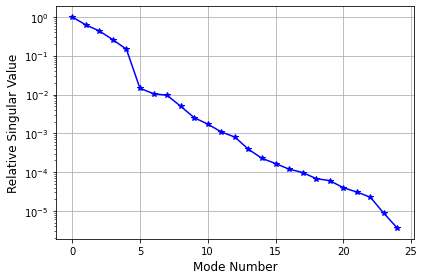

In [43]:
print("Fitting the ROM to all available data...")
t_start = time.time()
pod.fit(X, Y, 'rbf')
t_end = time.time()
print(f"Fitting took {t_end-t_start:.3f} s.")

pod.plot_singular_values()

Generate Random Samples and Query the ROM


In [44]:
rng = np.random.default_rng()
bounds = dataset.parameter_bounds
samples = np.zeros((n_samples, dataset.n_parameters))
for p in range(samples.shape[1]):
    samples[:, p] = rng.uniform(*bounds[p], n_samples)

qoi = np.zeros((n_samples,))
dt = np.diff(dataset.times)[0]

# POD predictions
print("Starting ROM queries...")
t_start = time.time()
X_pod = pod.predict(samples)
X_pod = dataset.unstack_simulation_vector(X_pod)
for i in range(n_samples):
    qoi[i] = QoI(X_pod[i])
t_end = time.time()
print(f"ROM queries took {t_end-t_start:.3f} s.")

Starting ROM queries...


KeyboardInterrupt: 

In [ ]:
import seaborn as sb

print(f"Mean of Time-Eigenvalue:\t{np.mean(qoi):.3e}.")
print(f"Std. Dev. of Time-Eigenvalue:\t{np.std(qoi):.3e}")

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(1, 1, 1)
xlabel = r"$\alpha_{0}$ ($\mu$s$^{-1}$)"
ylabel = "Probability"
sb.histplot(qoi, stat='probability', kde=True, ax=ax)
ax.set_xlabel(xlabel, fontsize=12)
ax.set_ylabel(ylabel, fontsize=12)
ax.grid(True)
plt.tight_layout()
# fig.savefig("/Users/zacharyhardy/Documents/phd/dissertation/"
#         "dissertation/figures/chapter10/sphere/"
#         "alpha_rom.pdf")
